# Chapter 9: Markov Chain Monte Carlo

Statistical Rethinking, 2nd Edition

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import warnings
from scipy import stats

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
az.rcParams["stats.credible_interval"] = 0.89  # sets default credible interval used by arviz
np.random.seed(0)

#### Code 9.1

In [3]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
current = 10
for i in range(num_weeks):
    # record current position
    positions[i] = current
    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # loop around the archipelago
    if proposal < 1:
        proposal = 10
    if proposal > 10:
        proposal = 1
    # move?
    prob_move = proposal / current
    if np.random.uniform() < prob_move:
        current = proposal

#### Code 9.2 & 9.3

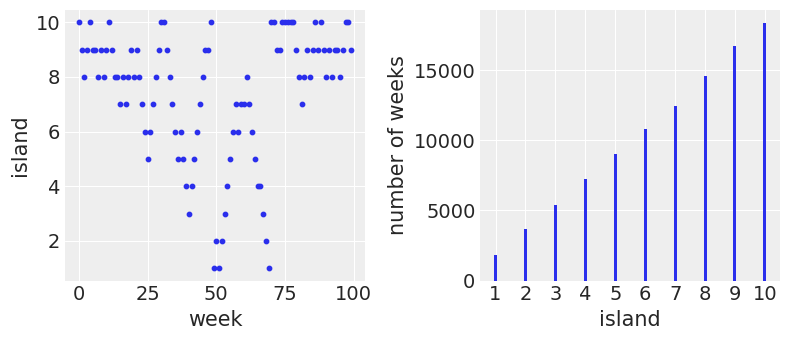

In [4]:
# Figure 9.2
fig, axs = plt.subplots(1, 2, figsize=[8, 3.5])

ax0, ax1 = axs

nplot = 100
ax0.scatter(range(nplot), positions[:nplot], s=10)
ax0.set_ylabel("island")
ax0.set_xlabel("week")

counts, _ = np.histogram(positions, bins=10)
ax1.bar(range(10), counts, width=0.1)
ax1.set_ylabel("number of weeks")
ax1.set_xlabel("island")
ax1.set_xticks(range(10))
ax1.set_xticklabels(range(1, 11))

fig.tight_layout()

#### Code 9.4

Text(0, 0.5, 'Density')

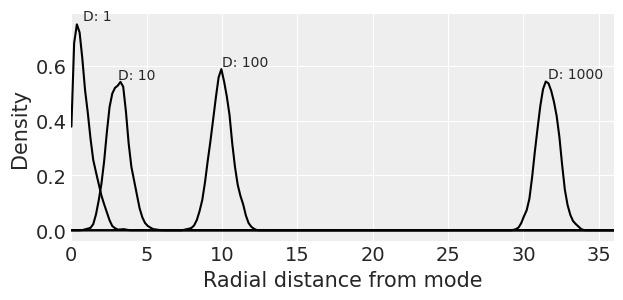

In [5]:
def rad_dist(Y):
    return np.sqrt(np.sum(Y ** 2))


fig, ax = plt.subplots(1, 1, figsize=[7, 3])
xvar = np.linspace(0, 36, 200)

# the book code is wrapped in a loop to reproduce Figure 9.4
for D in [1, 10, 100, 1000]:
    T = int(1e3)
    Y = stats.multivariate_normal(np.zeros(D), np.identity(D)).rvs(T)

    Rd = list(map(rad_dist, Y))

    kde = stats.gaussian_kde(Rd)
    yvar = kde(xvar)
    ax.plot(xvar, yvar, color="k")

    ax.text(np.mean(Rd), np.max(yvar) * 1.02, f"D: {D}")

ax.set_xlim(0, 36)
ax.set_xlabel("Radial distance from mode")
ax.set_ylabel("Density")

#### Code 9.5

In [6]:
# Note: this function makes use of global variables x and y.
# This is generally a bad idea and can lead to condsiderable
# confusion, but is preserved here to be true to the original.
def calc_U(q, a=0, b=1, k=0, d=1):
    muy, mux = q

    U = (
        np.sum(stats.norm.logpdf(y, loc=muy, scale=1))
        + np.sum(stats.norm.logpdf(x, loc=mux, scale=1))
        + stats.norm.logpdf(muy, loc=a, scale=b)
        + stats.norm.logpdf(mux, loc=k, scale=d)
    )

    return -U

#### Code 9.6

In [7]:
# gradient function
# need vector of partial derivatives of U with respect to vector q


# Note: this function makes use of global variables x and y.
# This is generally a bad idea and can lead to condsiderable
# confusion, but is preserved here to be true to the original.
def calc_U_gradient(q, a=0, b=1, k=0, d=1):
    muy, mux = q

    G1 = np.sum(y - muy) + (a - muy) / b ** 2  # dU/dmuy
    G2 = np.sum(x - mux) + (k - mux) / b ** 2  # dU/dmux

    return np.array([-G1, -G2])

In [8]:
# test data
y = np.random.normal(size=50)
x = np.random.normal(size=50)

#### Code 9.8 - 9.10

9.7 uses the function defined here, so is below

In [9]:
def HMC2(U, grad_U, epsilon, L, current_q):
    q = current_q
    p = np.random.normal(loc=0, scale=1, size=len(q))  # random flick - p is momentum
    current_p = p
    # Make a half step for momentum at the beginning
    p -= epsilon * grad_U(q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = np.full((L + 1, len(q)), np.nan)
    ptraj = qtraj.copy()
    qtraj[0, :] = current_q
    ptraj[0, :] = p

    # Code 9.9 starts here
    # Alternate full steps for position and momentum
    for i in range(L):
        q += epsilon * p  # Full step for the position
        qtraj[i + 1, :] = q
        # Make a full step for the momentum, except at the end of trajectory
        if i != L - 1:
            p -= epsilon * grad_U(q)
            ptraj[i + 1, :] = p

    # Make a half step for momentum at the end
    p -= epsilon * grad_U(q) / 2
    ptraj[L, :] = p
    # Negate momentum at end of trajectory to make the proposal symmetric
    p *= -1
    # Evaluate potential and kinetic energies sat start and end of trajectory
    current_U = calc_U(current_q)
    current_K = np.sum(current_p ** 2) / 2
    proposed_U = calc_U(q)
    proposed_K = np.sum(p ** 2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = False
    if np.random.uniform() < np.exp(current_U - proposed_U + current_U - proposed_K):
        new_q = q  # accept
        accept = True
    else:
        new_q = current_q  # reject

    return dict(q=new_q, traj=qtraj, ptraj=ptraj, accept=accept)

#### Code 9.7

This code expands upon 9.7 to produce both panels in the top row of Figure 9.6 (the bottom row requires a substantial re-write of calc_U and calc_U_grad to work with correlated distributions.

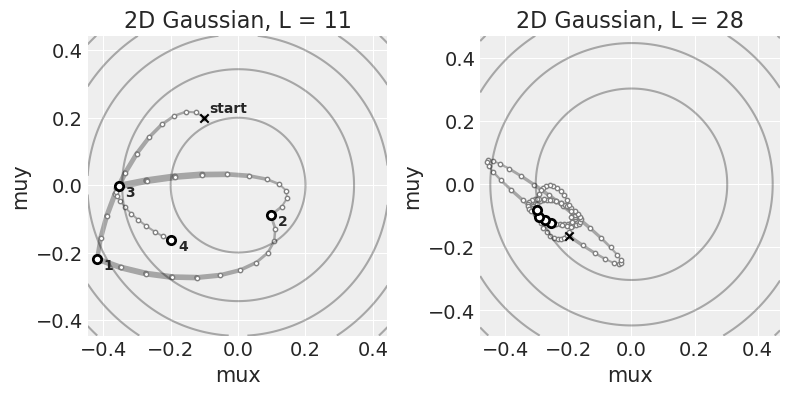

In [10]:
np.random.seed(13)
Q = {}
Q["q"] = np.array([-0.1, 0.2])
pr = 0.3
step = 0.03
# L = 11  # 0.03 / 28 for U-turns -- 11 for working example
n_samples = 4

fig, axs = plt.subplots(1, 2, figsize=[8, 4])

for L, ax in zip([11, 28], axs):
    ax.scatter(*Q["q"], color="k", marker="x", zorder=3)
    if L == 11:
        ax.text(*Q["q"] + 0.015, "start", weight="bold")
    for i in range(n_samples):
        Q = HMC2(calc_U, calc_U_gradient, step, L, Q["q"])
        ax.scatter(*Q["q"], color="w", marker="o", edgecolor="k", lw=2, zorder=3)
        if n_samples < 10:
            for j in range(L):
                K0 = np.sum(Q["ptraj"][j, :] ** 2) / 2  # kinetic energy
                ax.plot(
                    Q["traj"][j : j + 2, 0],
                    Q["traj"][j : j + 2, 1],
                    color="k",
                    lw=1 + 1 * K0,
                    alpha=0.3,
                    zorder=1,
                )
            ax.scatter(
                *Q["traj"].T, facecolor="w", edgecolor="gray", lw=1, zorder=2, s=10
            )
            if L == 11:
                ax.text(*Q["q"] + [0.02, -0.03], f"{i + 1}", weight="bold")

    ax.set_title(f"2D Gaussian, L = {L}")
    ax.set_xlabel("mux")
    ax.set_ylabel("muy")

    # draw background contours
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = np.max(abs(np.concatenate([xlim, ylim])))
    xs, ys = np.mgrid[-lim:lim:0.01, -lim:lim:0.01]
    p = (
        stats.multivariate_normal([0, 0], np.identity(2))
        .pdf(np.vstack([xs.flat, ys.flat]).T)
        .reshape(xs.shape)
    )
    ax.contour(xs, ys, p, 4, colors=[(0, 0, 0, 0.3)])
    ax.set_aspect(1)

fig.tight_layout()

#### Code 9.11

In [11]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

d["log_gdp"] = np.log(d["rgdppc_2000"])

dd = d.dropna(subset=["log_gdp"])
dd.loc[:, "log_gdp_std"] = dd.loc[:, "log_gdp"] / dd["log_gdp"].mean()
dd.loc[:, "rugged_std"] = dd.loc[:, "rugged"] / dd["rugged"].max()

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Code 9.12-9.18

By using PyMC3 we are already doing everything in these code blocks (No-Uturn sampling, parallell processing).

To translate the results of `summary` to `rethinking`'s `precis`:

 - `n_eff = ess_mean`
 - `Rhat4 = r_hat`

In [12]:
cid = pd.Categorical(dd["cont_africa"])

with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[cid] + b[cid] * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_3_trace = pm.sample()

az.summary(m_8_3_trace, kind="all", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 844.31draws/s] 


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.05,0.01,1.03,1.07,0.0,0.0,1190.45,1190.45,1195.20,857.40,1.01
a[1],0.88,0.02,0.86,0.91,0.0,0.0,1006.31,1006.31,988.28,723.71,1.00
b[0],-0.14,0.06,-0.24,-0.06,0.0,0.0,2242.47,1970.53,2115.27,640.15,1.00
b[1],0.13,0.08,-0.01,0.23,0.0,0.0,1126.69,906.37,1122.71,647.18,1.00
sigma,0.11,0.01,0.10,0.12,0.0,0.0,1321.29,1321.29,1303.96,851.59,1.00


#### Code 9.19

**Note:** kde plots on the diagonal will be supported in the next release of arviz by setting `marginals=True`

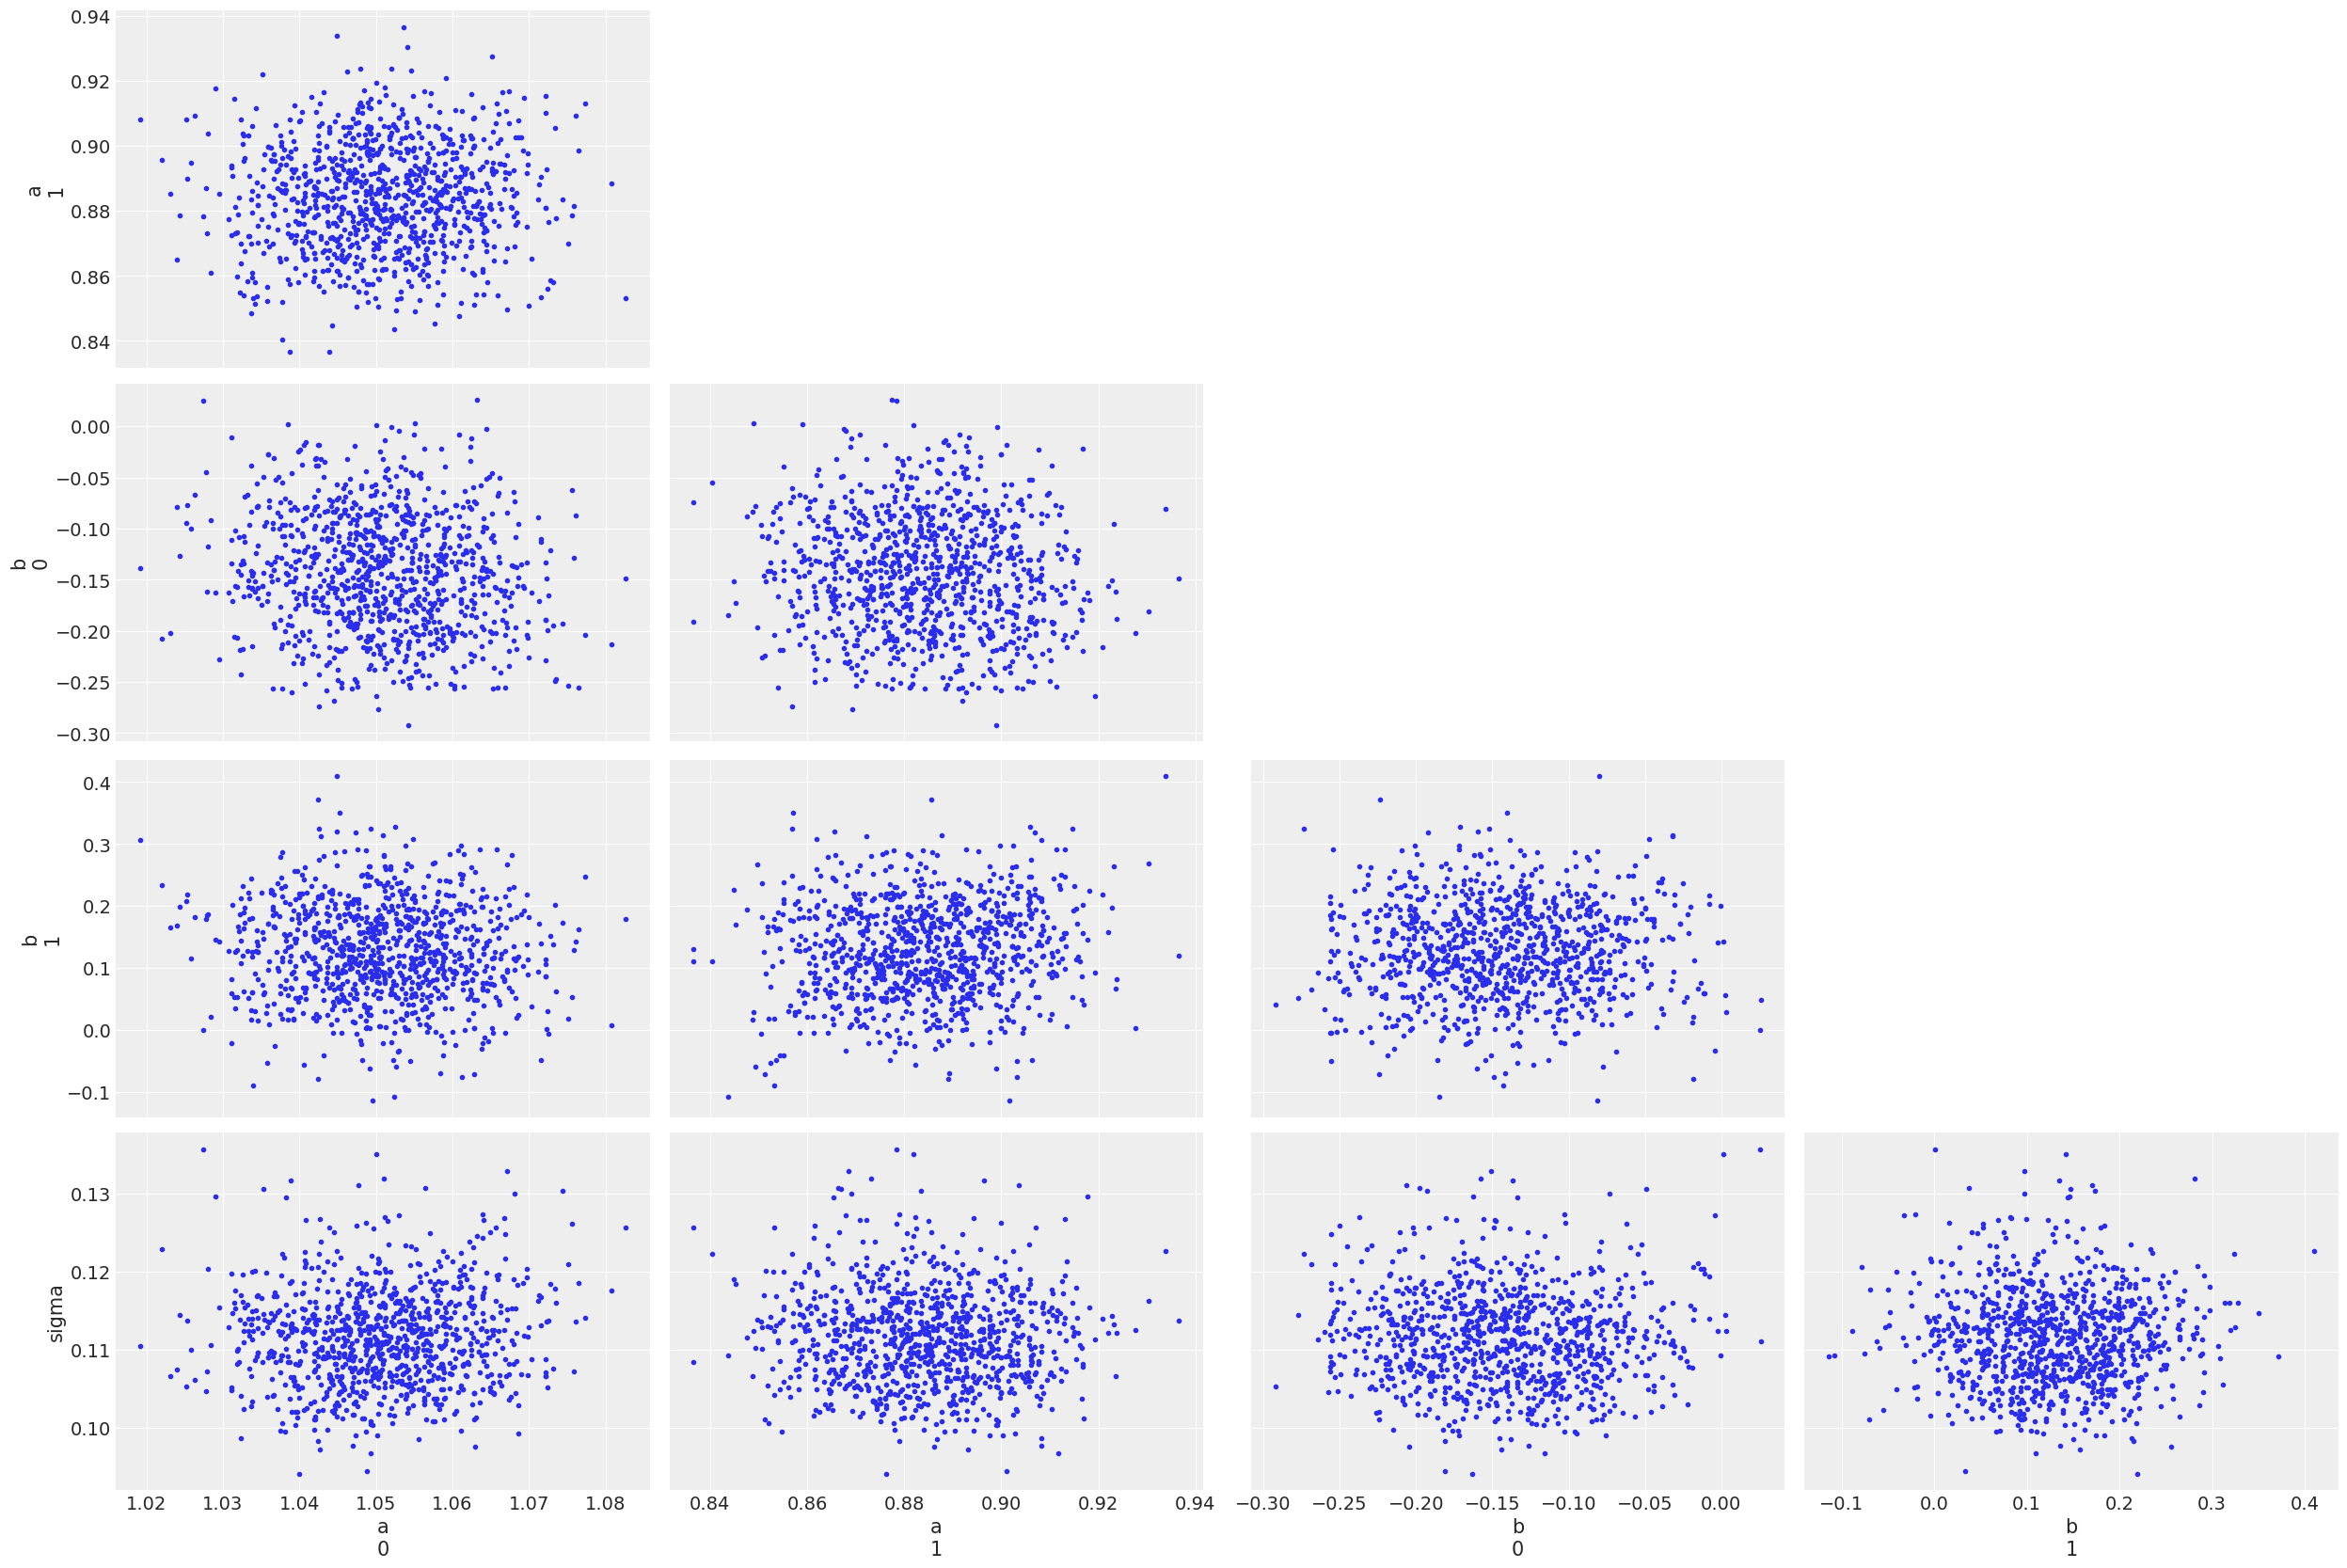

In [13]:
az.plot_pair(m_8_3_trace);

#### Code 9.20

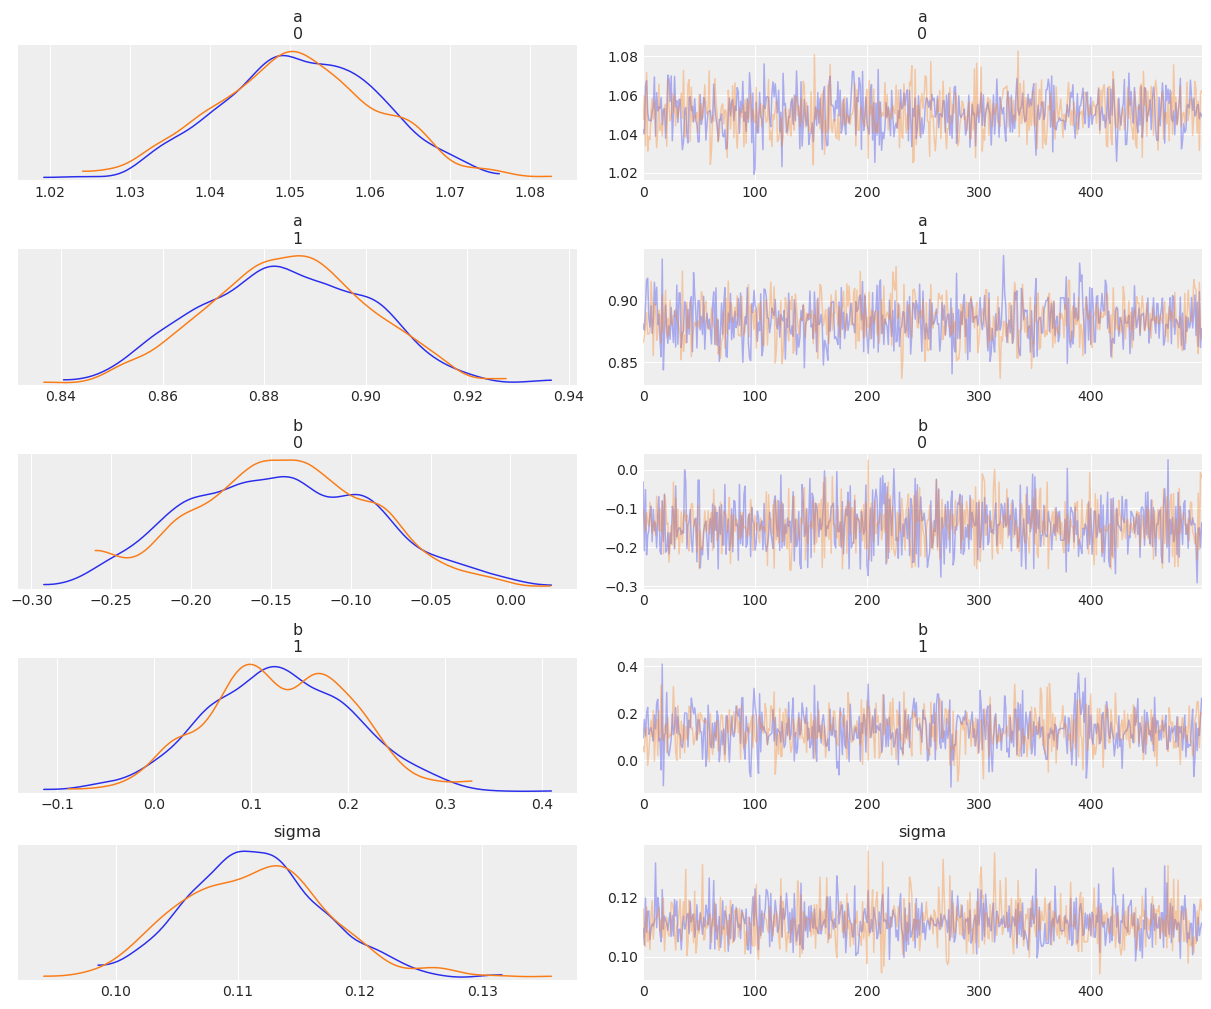

In [14]:
az.plot_trace(m_8_3_trace);

#### Code 9.21

This will be possible in the next version of `arviz` using the `kind` argument of `plot_trace`

#### Code 9.22

In [15]:
y = np.array([-1, 1])

with pm.Model() as m_9_2:
    alpha = pm.Normal("alpha", 0, 1000)

    mu = alpha
    sigma = pm.Exponential("sigma", 0.0001)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_2_trace = pm.sample(chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 3 chains, 51 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 663.65draws/s]
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9021067769266762, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9400882121464245, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


#### Code 9.23

In [16]:
az.summary(m_9_2_trace, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.57,394.94,-477.11,647.96,27.94,24.18,199.83,133.92,169.08,176.18,1.09
sigma,751.84,1592.09,1.96,1745.36,89.22,63.14,318.45,318.45,21.28,36.46,1.13


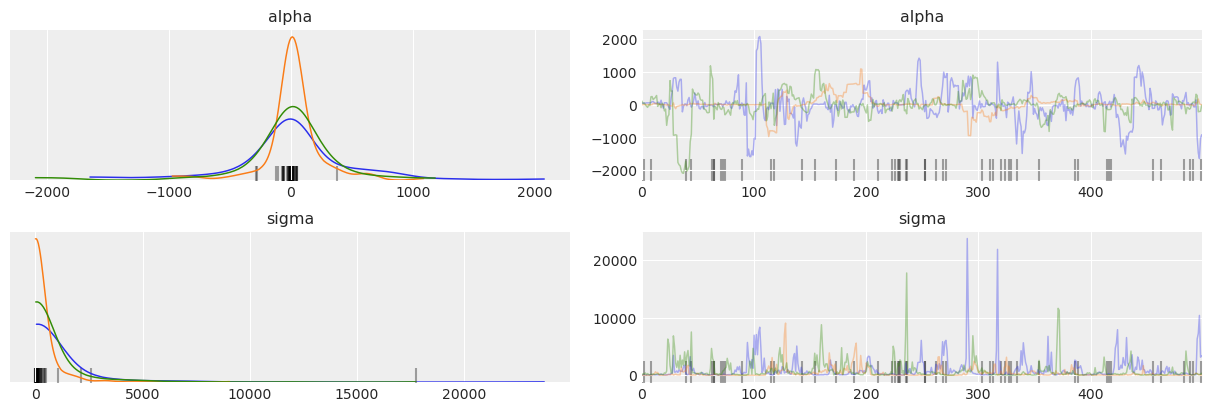

In [17]:
# Figure 9.9 (top)
az.plot_trace(m_9_2_trace);

#### Code 9.24

In [18]:
with pm.Model() as m_9_3:
    alpha = pm.Normal("alpha", 1, 10)

    mu = alpha
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_3_trace = pm.sample(chains=3)

az.summary(m_9_3_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 3 chains, 1 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1016.55draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7158174920175511, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.07,1.20,-1.78,1.90,0.06,0.06,403.68,239.23,500.01,329.65,1.01
sigma,1.52,0.87,0.52,2.62,0.04,0.03,389.11,389.11,350.17,411.04,1.00


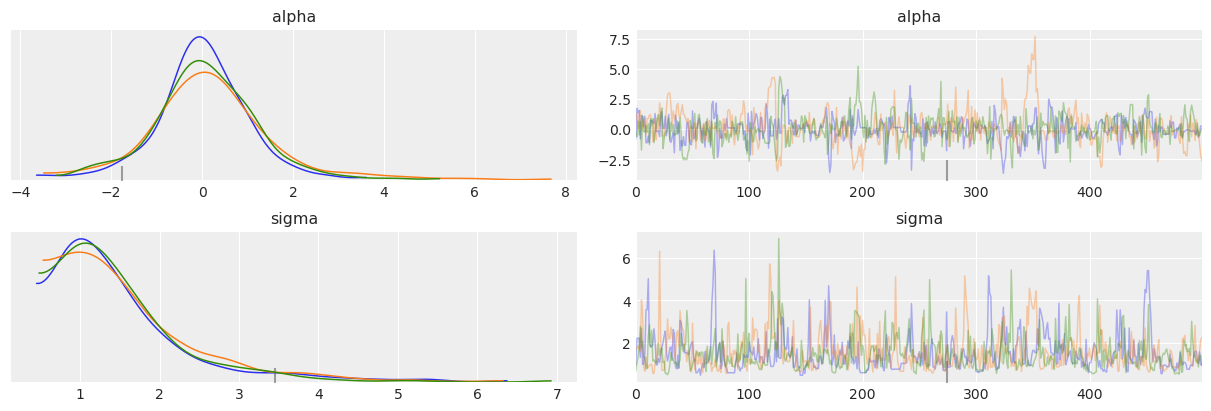

In [19]:
# Figure 9.9 (bottom)
az.plot_trace(m_9_3_trace);

100%|██████████| 10000/10000 [00:00<00:00, 18795.32it/s]


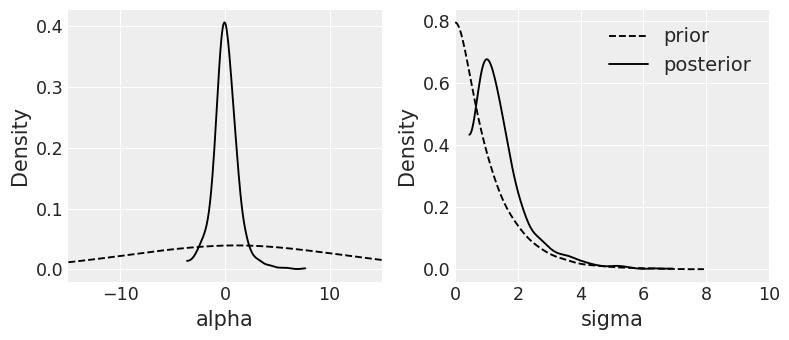

In [20]:
# Figure 9.10
with m_9_3:
    m_9_3_prior = pm.sample_prior_predictive(int(1e4), vars=["alpha", "sigma"])
    m_9_3_post = pm.sample_posterior_predictive(
        m_9_3_trace, int(1e4), vars=[alpha, sigma]
    )

fig, axs = plt.subplots(1, 2, figsize=[8, 3.5])
ax0, ax1 = axs

az.plot_kde(m_9_3_prior["alpha"], ax=ax0, plot_kwargs={"color": "k", "ls": "dashed"})
az.plot_kde(m_9_3_post["alpha"], ax=ax0, plot_kwargs={"color": "k"})
ax0.set_xlim(-15, 15)
ax0.set_xlabel("alpha")

az.plot_kde(
    m_9_3_prior["sigma"],
    ax=ax1,
    plot_kwargs={"color": "k", "ls": "dashed"},
    label="prior",
)
az.plot_kde(m_9_3_post["sigma"], ax=ax1, plot_kwargs={"color": "k"}, label="posterior")
ax1.legend()
ax1.set_xlim(0, 10)
ax1.set_xlabel("sigma")

for ax in axs:
    ax.set_ylabel("Density")

fig.tight_layout()

#### Code 9.25

In [21]:
y = np.random.normal(loc=0, scale=1, size=100)

#### Code 9.26

In [22]:
with pm.Model() as m_9_4:
    a1 = pm.Normal("a1", 0, 1000)
    a2 = pm.Normal("a2", 0, 1000)

    mu = a1 + a2
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_4_trace = pm.sample(chains=3)

az.summary(m_9_4_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 3 chains, 77 divergences: 100%|██████████| 3000/3000 [03:06<00:00, 16.11draws/s] 
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14907922391485084, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a1,69.56,429.11,-409.86,626.90,233.93,182.34,3.36,3.36,3.93,26.62,2.15
a2,-69.50,429.12,-626.98,409.98,233.93,182.34,3.36,3.36,3.93,25.47,2.15
sigma,0.93,0.06,0.86,1.04,0.02,0.02,5.93,5.93,7.54,71.45,2.03


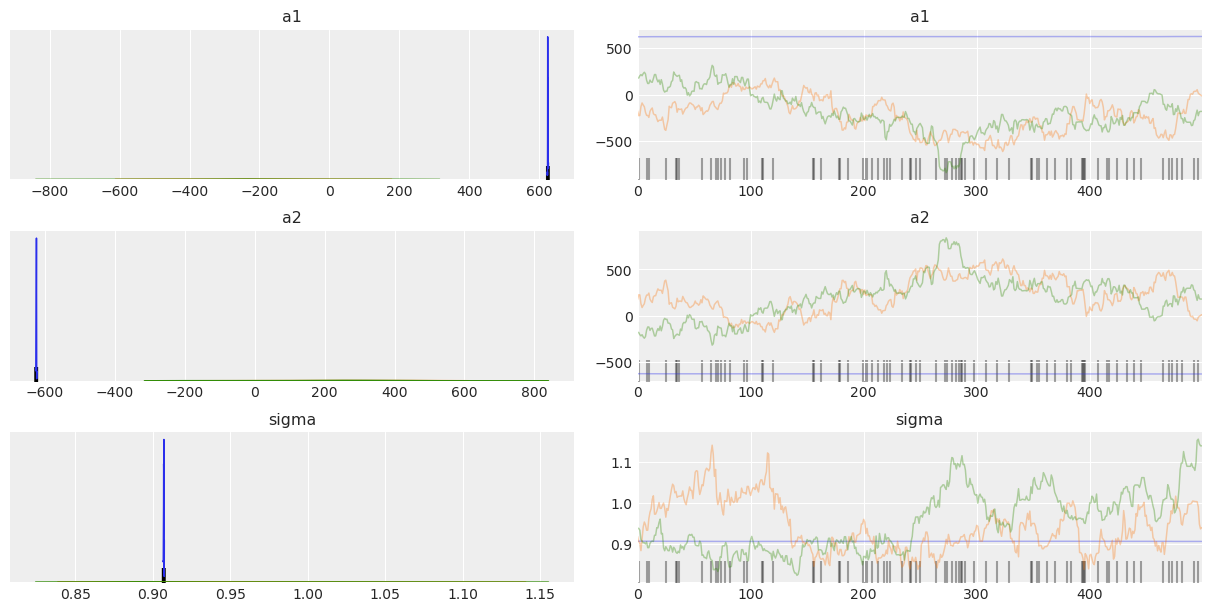

In [23]:
# Figure 9.11 (top half)
az.plot_trace(m_9_4_trace);

#### Code 9.27

In [24]:
with pm.Model() as m_9_5:
    a1 = pm.Normal("a1", 0, 10)
    a2 = pm.Normal("a2", 0, 10)

    mu = a1 + a2
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_5_trace = pm.sample(chains=3)

az.summary(m_9_5_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 3 chains, 0 divergences: 100%|██████████| 3000/3000 [01:12<00:00, 41.60draws/s]
The acceptance probability does not match the target. It is 0.8946853941400075, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a1,-0.39,7.17,-12.72,10.37,0.35,0.25,417.58,417.58,419.50,430.62,1.01
a2,0.45,7.17,-10.40,12.74,0.35,0.25,417.45,417.45,420.15,437.27,1.01
sigma,0.96,0.07,0.84,1.06,0.00,0.00,647.67,631.87,652.93,494.88,1.01


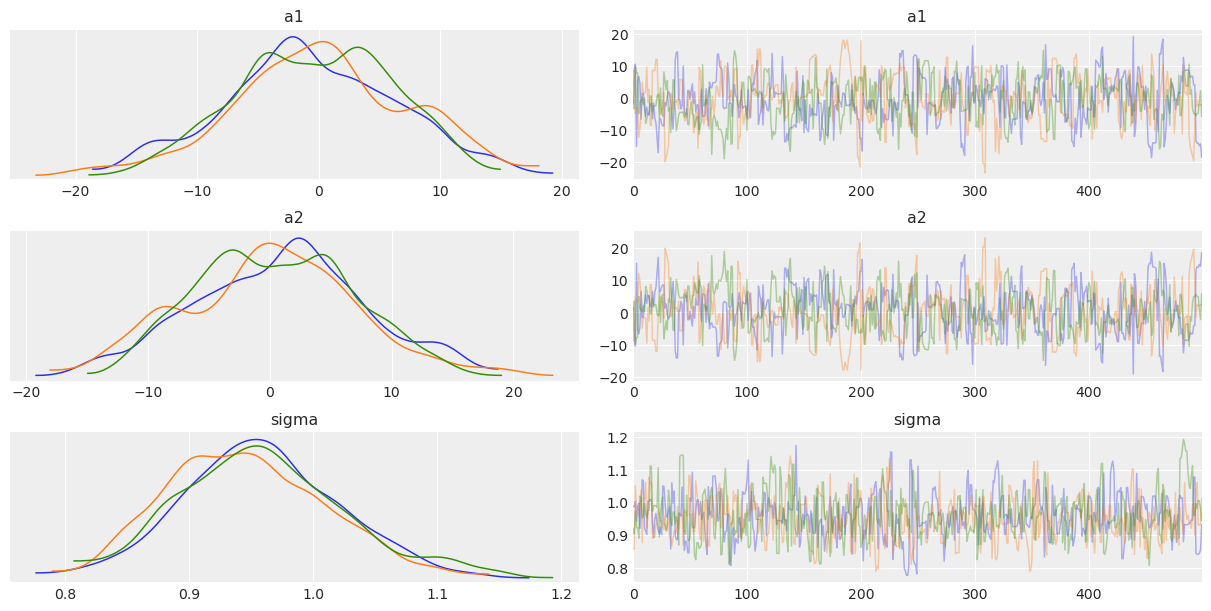

In [25]:
# Figure 9.11 (bottom half)
az.plot_trace(m_9_5_trace);

In [26]:
%load_ext watermark
%watermark -v -iv -w

numpy  1.18.1
pandas 1.0.3
arviz  0.7.0
pymc3  3.8
CPython 3.7.6
IPython 7.14.0
watermark 2.0.2
